# Playground with sampled data from KiT-RT

### Setup

Note that `moments_conserve` function does not work for this case

In [1]:
using KitBase, Distributions, LinearAlgebra, Flux
using KitBase.Plots, KitBase.JLD2, KitBase.WriteVTK
using Flux: @epochs

┌ Info: Precompiling KitBase [86eed249-3a28-466f-8d3a-596821e1af9a]
└ @ Base loading.jl:1342
┌ Info: Kinetic will run serially
└ @ KitBase /home2/vavrines/.julia/packages/KitBase/S6IkZ/src/KitBase.jl:61
┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1342


In [2]:
function get_moments(f, u, v, ω)
    w = zeros(eltype(f), 4)
    w[1] = discrete_moments(f, u, ω, 0)
    w[2] = discrete_moments(f, u, ω, 1)
    w[3] = discrete_moments(f, v, ω, 1)
    w[4] = 0.5 * (discrete_moments(f, u, ω, 2) + discrete_moments(f, v, ω, 2))
    return w
end

function regime_data(w, swx, swy, f, u, v, K, Kn, μ=ref_vhs_vis(Kn, 1.0, 0.5), ω=0.81)
    gam = heat_capacity_ratio(K, 2)
    prim = conserve_prim(w, gam)
    Mu, Mv, Mxi, _, _1 = gauss_moments(prim, K)
    a = pdf_slope(prim, swx, K)
    b = pdf_slope(prim, swy, K)
    swt = -prim[1] .* (moments_conserve_slope(a, Mu, Mv, Mxi, 1, 0) .+ moments_conserve_slope(b, Mu, Mv, Mxi, 0, 1))
    A = pdf_slope(prim, swt, K)
    
    tau = vhs_collision_time(prim, μ, ω)
    fr = chapman_enskog(u, v, prim, a, b, A, tau)
    L = norm((f .- fr) ./ prim[1])
    sw = (swx.^2 + swy.^2).^0.5
    x = [w; sw; tau]
    y = ifelse(L <= 0.005, 0.0, 1.0)
    return x, y
end

function regime_number(Y, rg=0)
   idx = 0
    for i in axes(Y, 2)
       if Y[1, i] == rg
            idx += 1
        end
    end
    println("NS regime: $(idx) of $(size(Y, 2))")
    return nothing
end

function accuracy(nn, X, Y)
    Y1 = nn(X)

    YA1 = [onecold(Y1[:, i]) for i in axes(Y1, 2)]
    YA = [onecold(Y[:, i]) for i in axes(Y, 2)]

    accuracy = 0.0
    for i in eachindex(YA)
        if YA[i] == YA1[i]
            accuracy += 1.0
        end
    end
    accuracy /= length(YA)

    return accuracy
end

accuracy (generic function with 1 method)

In [3]:
file = open("/home2/vavrines/Coding/KiT-RT/result/logs/a2_ev5.csv")
data = []
for line in eachline(file)
    a = split(line, ",")
    b = [parse(Float64, a[i]) for i = 2:length(a)]
    push!(data, b)
end
pdfs = data[5:end]
nd = length(pdfs) ÷ 2

5000

In [4]:
nqa = sqrt(length(data[1])) |> Int
vs = VSpace2D(-5.0, 5.0, nqa, -5.0, 5.0, nqa, data[1], data[2], zero(data[1]), zero(data[2]), data[4])

VelocitySpace2D{Float64,Int64,Vector{Float64}}
domain: (-5.0,5.0) × (-5.0,5.0)
resolution: 80 × 80
ghost in u: 0
ghost in v: 0


In [5]:
dist = Uniform(0.005, 0.1)
dxs = rand(dist, nd)
dist = Uniform(0.005, 0.1)
dys = rand(dist, nd)
dist = Uniform(0.0001, 1.0)
kns = rand(dist, nd);
dist = Uniform(0.1, 1.0)
rhos = rand(dist, nd); rhos .= 1.;

In [6]:
X = [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Y = [0.0]
for i = 1:nd÷2
    try
        #fL = pdfs[i]; fR = pdfs[nd*2-i]
        fL = pop!(pdfs) .* pop!(rhos); fR = pop!(pdfs) .* pop!(rhos) # shuffle
        wL = get_moments(fL, vs.u, vs.v, vs.weights); wR = get_moments(fR, vs.u, vs.v, vs.weights)

        δx, δy = dxs[i], dys[i]
        n = [δx, δy] ./ norm([δx, δy])
        vn = vs.u .* n[1] .+ vs.v .* n[2]
        vt = vs.v .* n[1] .- vs.u .* n[2]
        δ = heaviside.(vn)
        f = @. fL * δ + fR * (1.0 - δ)
        w = get_moments(f, vs.u, vs.v, vs.weights)
        
        swx = @. (wR - wL) / δx
        swy = @. (wR - wL) / δy
        
        tmpx, tmpy = regime_data(w, swx, swy, f, vs.u, vs.v, 0, kns[i])
        X = hcat(X, tmpx)
        Y = hcat(Y, tmpy)
    catch
        println("error at ($i)-th data")
    end
end

In [7]:
X

9×2501 Matrix{Float64}:
 1.0   1.0          1.0          1.0          …  1.0           1.0
 0.0  -0.000219857  0.000199761  0.000400911     0.000813166  -2.53749e-5
 0.0  -0.000453982  5.42815e-7   2.10801e-5      0.00167126   -0.00105989
 1.0   0.951908     0.951893     0.951892        0.951913      0.951892
 0.0   1.86264e-11  7.16228e-11  1.08932e-11     2.16972e-11   3.89125e-11
 0.0   5.12273e-17  2.74084e-17  2.89683e-16  …  3.82513e-18   1.36063e-16
 0.0   1.29677e-16  9.61057e-16  2.09483e-16     1.11423e-16   2.74474e-16
 0.0   0.000366162  0.00031827   0.000185415     0.00197526    0.000445308
 1.0   0.87954      0.709907     0.173576        0.400963      0.308528

In [8]:
Y

1×2501 Matrix{Float64}:
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [9]:
regime_number(Y)

NS regime: 1 of 2501


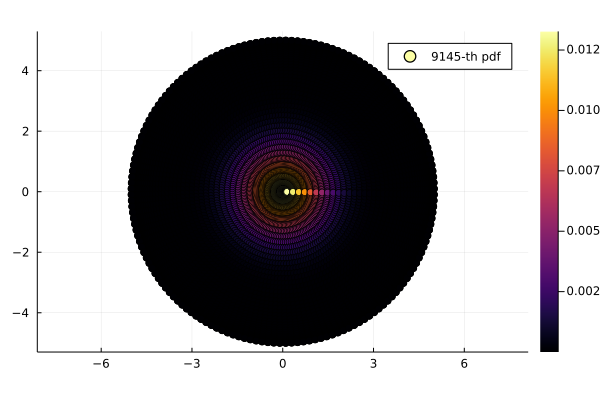

In [111]:
idx = rand() * length(data) |> floor |> Int
scatter(vs.u, vs.v, marker_z=data[idx], legend=true, ratio=1, label="$(idx)-th pdf") # colored scatter plot